Подключение библиотек и функция пасинга для получения курса валюты на нынешний момент с сайта myfin.by

In [1]:
import re
import requests 
from bs4 import BeautifulSoup

link = "https://myfin.by/currency/minsk"
headers = {'User-Agent': 'Chrome/80.0.3987.149'}

full_page = requests.get(link, headers=headers).text
soup = BeautifulSoup(full_page, "html.parser")


def parse_bank_by_id(id): # 11, 14, 27
    rate = soup.find_all('tr', {'data-bank_id': str(id)})[0]
    return re.findall(re.compile(r"<td>(.*?)</td>"), str(rate))[0]

Методы для работы с базой данных sqlite3

In [2]:
import sqlite3
from sqlite3 import Error


db_file = r"pythonsqlite.db"


def create_connection():
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

            
def create_table(table):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
#         cur.execute("DROP TABLE IF EXISTS `{}`".format(table))
        cur.execute("CREATE TABLE IF NOT EXISTS `{}` ( \
                    `id` INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, \
                    `rate` REAL, \
                    `bank` TEXT, \
                    `currency` TEXT, \
                    `timestamp` DATETIME DEFAULT CURRENT_TIMESTAMP)".format(table))
        print("Table {} created".format(table))
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
            
def insert_into_table(table, bank, currency, rate):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute("INSERT INTO `{0}` (`bank`, `currency`, `rate`, `timestamp`) \
                    VALUES ('{1}', '{2}', {3}, date('now'))".format(table, bank, currency, rate))
        conn.commit()
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            

def select_from_table(table):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute("SELECT * FROM `{}`".format(table))
#         print(cur.fetchall())
        for row in cur:
            print(row)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

        
def select_from_table_between(table, start_date, end_date):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cur = conn.cursor()
        cur.execute("SELECT * FROM `{}` WHERE `timestamp` \
                    BETWEEN '{}' AND '{}'".format(table, start_date, end_date))
        for row in cur:
            print(row)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()


create_connection()
# create_table("rates")
# insert_into_table("rates", "belinvest", "USD", 2.55)
# insert_into_table("rates", "priorbank", "USD", 2.55)
# insert_into_table("rates", "belarusbank", "USD", 2.55)
# insert_into_table("rates", "statusbank", "USD", 2.55)
# select_from_table("rates")
# select_from_table_before("rates", "2021-11-10", "2021-11-21")

# insert_into_table("rates", "belarusbank", "USD", parse_bank_by_id(11))
# insert_into_table("rates", "belinvestbank", "USD", parse_bank_by_id(14))
# insert_into_table("rates", "priorbank", "USD", parse_bank_by_id(27))
# select_from_table_between("rates", "2021-11-10", "2021-12-21")

2.6.0


Методы для получения архива курсов валют по API с сайта nbrb.by

In [3]:
import requests

def get_rate(date):
    url = 'https://www.nbrb.by/api/exrates/rates/USD?parammode=2&ondate={}'.format(date)
    r = requests.get(url) 
    response = r.json() 
    return response["Cur_OfficialRate"]


def get_rates(startdate, findate):
    url = 'https://www.nbrb.by/api/exrates/rates/dynamics/431?startdate={}&enddate={}'.format(startdate, findate)
    r = requests.get(url) 
    response = r.json()
#     print(response)
    rates = list()
    for item in response:
        rates.append(item["Cur_OfficialRate"])
    return rates


import datetime

dt = datetime.date(2021, 12, 9)

rates = list()
for i in range(1000):
    rates.append((str(dt - datetime.timedelta(days=i)), get_rate(str(dt - datetime.timedelta(days=i)))))
rates = [item[1] for item in rates]

# rates = list()
# for step in range(10):
#     rates= get_rates(dt - datetime.timedelta(days=300*(step+1)), dt - datetime.timedelta(days=1+300*step)) + rates
#     print(get_rates(dt - datetime.timedelta(days=300*(step+1)), dt - datetime.timedelta(days=1+300*step)))
# print(rates)

Подключение библиотек для использования tensorflow. Функция univariate_data использована для вычисления интервалов для обучения модели.

array([<AxesSubplot:>], dtype=object)

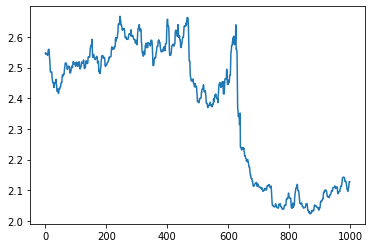

In [4]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


uni_data = pd.Series(rates, copy=False)

uni_data.plot(subplots=True)

Выделение наборов для обучения и валидирования в соотношении 9:1. Стандартизация набора данных

In [5]:
TRAIN_SPLIT = int(len(rates) * 0.9)

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

Задание объёма входных данных для предсказания результата моделью. 

In [6]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data.to_numpy(), 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data.to_numpy(), TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target rate to predict')
print (y_train_uni[0])

Single window of past history
[[0.71444782]
 [0.72500088]
 [0.70053698]
 [0.70677287]
 [0.70677287]
 [0.70677287]
 [0.70197603]
 [0.68230897]
 [0.71156972]
 [0.75570068]
 [0.77632711]
 [0.77632711]
 [0.77632711]
 [0.68086992]
 [0.62042968]
 [0.55615197]
 [0.44102771]
 [0.42088096]
 [0.42088096]
 [0.42088096]
 [0.42471844]
 [0.41896223]
 [0.33789556]
 [0.29760207]
 [0.25730858]
 [0.25730858]
 [0.25730858]
 [0.21749477]
 [0.18007939]
 [0.2198932 ]]

 Target rate to predict
0.24579615479041492


Функции для визуализации и визуализация ожидаемого результата.

<module 'matplotlib.pyplot' from 'C:\\Users\\StanVer\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

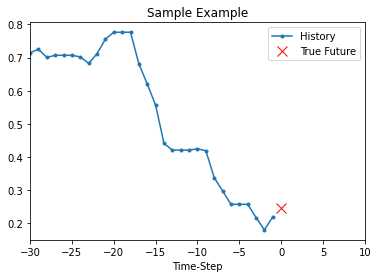

In [7]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Выполнение перемешвания, масштабирования и кэширования наборов данных.

In [8]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Задание параметров вычислений реккурентной нейронной сети.

In [9]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

(70, 1)
Epoch 1/10
200/200 [==============================] - 2s 7ms/step - loss: 0.5410 - val_loss: 0.1090
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0769 - val_loss: 0.0629
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0571 - val_loss: 0.0507
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0475 - val_loss: 0.0440
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0413 - val_loss: 0.0380
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0372 - val_loss: 0.0334
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0343 - val_loss: 0.0274
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0322 - val_loss: 0.0258
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0308 - val_loss: 0.0213
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0301 - val_loss

Демонстрация результатов работы модели.

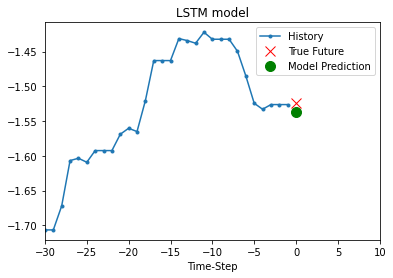

In [10]:
for x, y in val_univariate.take(1):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'LSTM model')
    plot.show()